# Qualitative Evaluation on self-trained embeddings

In [45]:
import argparse
import time
import math
import torch
import torch.nn as nn
from torch.autograd import Variable

import data
import model
import matplotlib.pyplot as plt

In [14]:
corpus = data.Corpus('./data/brown')

In [2]:
model_trained = torch.load('model_cpu.pt')

In [41]:
emb_trained = model_trained.encoder
emb_np = emb_trained.weight.data.numpy()

In [42]:
#TSNE Ploting
from sklearn.manifold import TSNE
TSNE_model = TSNE(n_components=2,random_state=0)

In [43]:
#Warning Long Training Process
representations2D = TSNE_model.fit_transform(emb_np)

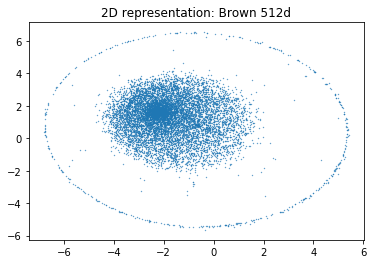

In [46]:
plt.scatter(representations2D[:,0],representations2D[:,1],s=0.1)
#for word_idx,word in enumerate(words_to_plot):
#    plt.annotate(word,representations2D[word_idx])
#plt.xlim([-100,100])
#plt.ylim([-100,100])
plt.title('2D representation: Brown 512d')
plt.show()

# Making Prediction

In [47]:
from nltk.corpus import semcor

In [54]:
example_sent = semcor.sents()[100]

In [63]:
context_eg = example_sent[4-3:4+3+1]
print(context_eg)

['If', 'you', 'destroy', 'confidence', 'in', 'banks', ',']


In [80]:
context_idx = Variable(torch.LongTensor([corpus.dictionary.word2idx[word] for word in context_eg]).view(-1,1))

In [61]:
holdout = context_eg[3]

In [88]:
context_idx[3] = 0

In [73]:
hidden = model_trained.init_hidden(1)

In [89]:
context_idx

Variable containing:
  799
  800
  801
    0
   26
  774
   31
[torch.LongTensor of size 7x1]

In [105]:
output,hidden = model_trained.forward(context_idx,hidden)

In [106]:
output_np = output.data.numpy()

In [116]:
best10 = sorted(output_np[0],reverse=True)[9]

In [117]:
best10

13.40598

In [118]:
import numpy as np
predictions = np.where(output_np>=best10)[1]

In [119]:
[corpus.dictionary.idx2word[idx] for idx in predictions]

['court',
 'home',
 'tax',
 'himself',
 'went',
 'once',
 'followed',
 'speak',
 'fell',
 'growing']

In [111]:
context_eg

['If', 'you', 'destroy', 'confidence', 'in', 'banks', ',']